# Pre Requisites

In [ ]:
# OCR Methods download

%%capture
!sudo apt install tesseract-ocr
# !sudo apt-get install gocr
# !sudo apt-get install ocrad
# !sudo apt-get install cuneiform
# !pip install easyocr
!pip install pytesseract

In [ ]:
# Python libraries download

%%capture
!pip install pyspellchecker -q
!pip install -U spacy
!python -m spacy download en_core_web_lg
!pip install pyopencl
!pip install pkg-resources

In [ ]:
import os
import glob
import cv2
from sys import getsizeof
import pytesseract
# import easyocr
import concurrent.futures
import time
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import itertools
nltk.download('words')
from nltk.corpus import words
from nltk.metrics.distance import edit_distance
import string
import re
import os
import spacy
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import files
# files.upload()

# Get the kaggle.json file form downloads

!sudo mkdir /root/.kaggle
!sudo cp '/content/drive/MyDrive/Important Keys/kaggle.json' /root/.kaggle/
!sudo chmod 600 /root/.kaggle/kaggle.json

In [ ]:
%%capture
!kaggle datasets download ishanmittal1404/indian-restaurant-menu-card-images
!unzip /content/indian-restaurant-menu-card-images.zip -d /content/images/
!rm /content/indian-restaurant-menu-card-images.zip

In [ ]:
!ls -l '/content/images' | egrep -c '^-'

7790


# Computer Vision

In [ ]:
directory = '/content/images'
image_files = glob.glob(os.path.join(directory, '*.[jp][pn]g'))

In [ ]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image):
    return cv2.medianBlur(image,3)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

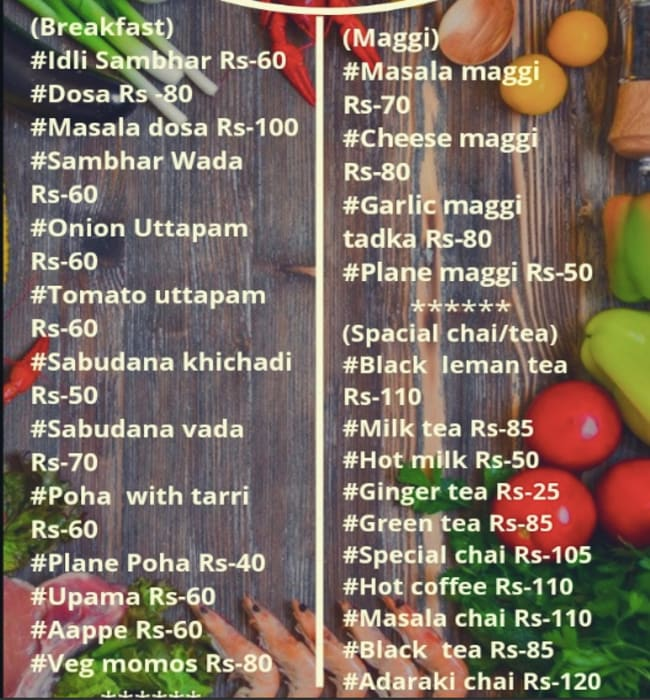

In [ ]:
img_test = image_files[35]
cv2_img = cv2.imread(img_test)
cv2_imshow(cv2_img)

In [ ]:
img = cv2.resize(cv2_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

img = get_grayscale(img)
img = remove_noise(img)
img = thresholding(img)

custom_config = r'-c tessedit_char_whitelist=ABCDEEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-₹//(), --psm 6'
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

2 ,
aN nv )
eaTolTaRY rRs-60 PYPTERr
DosaRsSQso Rs-7 - ,
MasaladdSaRs-100Jgchebhemaphi
etl ay
ied , f
4OnionUttapam Peet)
, death +PlanemaggiRs-50
arSeissTtday) peep
Lie (Spaci i a)
SabudanakhichadiBlac aU
Rs-50 CeaBT
Sabudanavada a Rs-85 a
Rs-70 tHot kRs-50
tara GingerteaRs-25
eesti) pabetpe CTL
gE PohaRs-40 SpecichaiRs-105
- Peon HotcoffeeRs-110
ganppenecoSfesattelR11
ye dinekinael ie Sea Rs-120



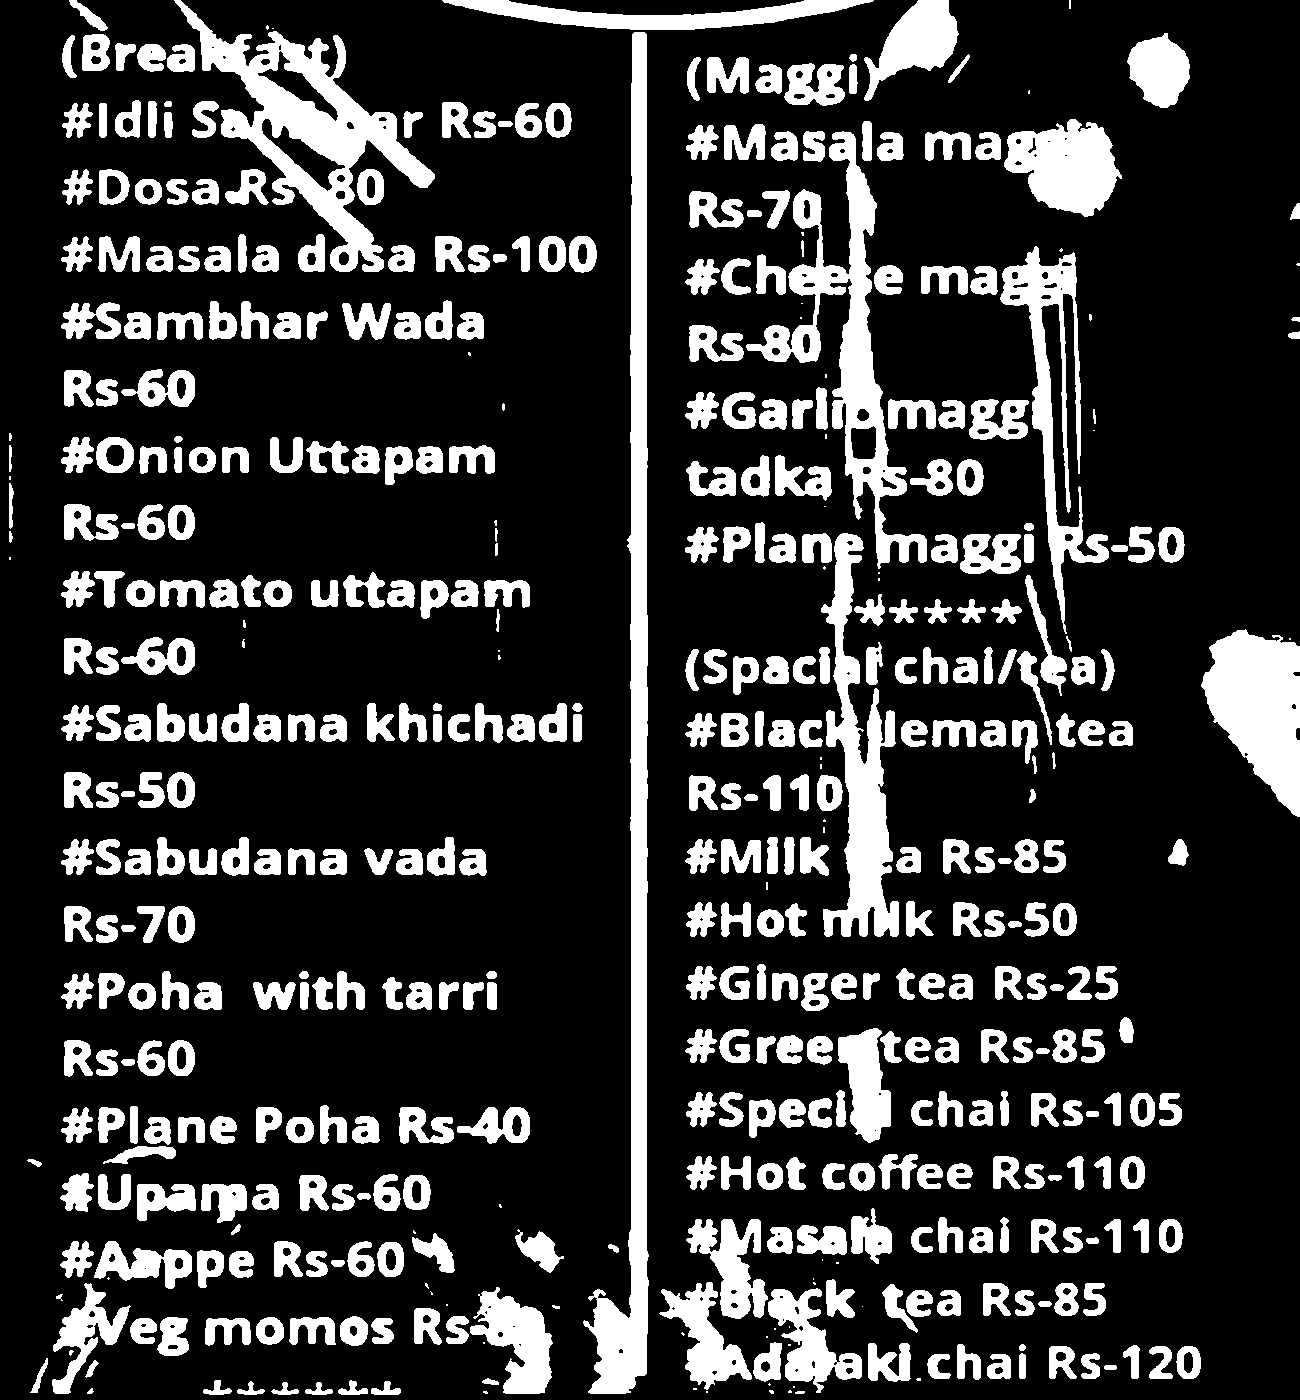

In [ ]:
cv2_imshow(img)

In [ ]:
uncorrected_text = []

for i in image_files[:1000]:
    cv2_img = cv2.imread(i)
    img = cv2.resize(cv2_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    img = get_grayscale(img)
    img = remove_noise(img)
    img = thresholding(img)

    text = pytesseract.image_to_string(img, config=custom_config).strip()
    uncorrected_text.append(text)

In [ ]:
print(f"{round( getsizeof(uncorrected_text)/1024, 9)} kB")
print(f"{round( getsizeof(uncorrected_text)/(1024**2), 9)} MB")

8.6484375 kB
0.00844574 MB


# Spelling Correction

In [ ]:
sp = spacy.load('en_core_web_lg')

In [ ]:
food = wn.synset('food.n.02')
fruit = wn.synset('fruit.n.01')
beverage = wn.synset("beverage.n.01")
vegetable = wn.synset("vegetable.n.01")
cuisine = wn.synset("cuisine.n.01")
bread = wn.synset("bread.n.01")
dessert = wn.synset("dessert.n.01")
food = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
fruit = list(set([w for s in fruit.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
beverage = list(set([w for s in beverage.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
vegetable = list(set([w for s in vegetable.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
cuisine = list(set([w for s in cuisine.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
bread = list(set([w for s in bread.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
dessert = list(set([w for s in dessert.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('lunch_meat.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('headcheese.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('haslet.n.01') at depth 3
  for synset in acyclic_breadth_first(self, rel, depth):
/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('leg_of_lamb.n.01') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):
/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('rack_of_lamb.n.01') at d

In [ ]:
correct_words = words.words()
correct_words.extend(food)
correct_words.extend(fruit)
correct_words.extend(beverage)
correct_words.extend(vegetable)
correct_words.extend(cuisine)
correct_words.extend(bread)
correct_words.extend(dessert)

In [ ]:
sen = sp(str(uncorrected_text[1]))
for word in sen[:10]:
    print(f'{word.text:{20}} {word.pos_:{10}} {word.tag_:{8}} {spacy.explain(word.tag_)}')

B                    NOUN       NN       noun, singular or mass
4                    NUM        CD       cardinal number
eS                   NOUN       NN       noun, singular or mass
sy                   PROPN      NNP      noun, proper singular
Qal-                 PROPN      NNP      noun, proper singular
19                   NUM        CD       cardinal number
G                    PROPN      NNP      noun, proper singular
eee                  PROPN      NNP      noun, proper singular

                    SPACE      _SP      whitespace
RICE                 NOUN       NN       noun, singular or mass


In [ ]:
ftext = []

for i in uncorrected_text:
    sen = sp(str(i))
    word_text = [word.text for word in sen]
    word_tags = [word.tag_ for word in sen]

    temp = []
    for i in range(len(word_text)):
        if word_tags[i] not in ['NNS', 'NN', 'NNP', 'CD', '_SP']:
            temp = [(edit_distance(word_text[i], w),w) for w in correct_words if w[0]==word_text[0]]
            if temp != []:
                temp.append(str(sorted(temp, key = lambda val:val[0])[0][1]) + ' ')
        else:
            temp.append(str(word_text[i]) + ' ')
    ftext.append(temp)

print(f"{round( getsizeof(ftext)/1024, 9)} kB")
print(f"{round( getsizeof(ftext)/(1024**2), 9)} MB")

# Trials

In [ ]:
from PIL import Image
import uuid

from subprocess import Popen, PIPE, call


def tesseract(mat, config=None):
    if config is None:
        text = pytesseract.image_to_string(Image.fromarray(mat))
    else:
        text = pytesseract.image_to_string(Image.fromarray(mat), config=config)

    return text


def gocr(mat, encoding="utf-8"):
    p = Popen(["gocr", "-"], stdin=PIPE, stdout=PIPE)
    retval, buf = cv2.imencode(".pgm", mat)

    p.stdin.write(buf)
    p.stdin.close()
    p.wait()
    text = p.stdout.read()
    p.stdout.close()

    return text.decode(encoding).strip("\n")


def ocrad(mat, encoding="utf-8"):
    p = Popen(["ocrad", "-"], stdin=PIPE, stdout=PIPE)
    retval, buf = cv2.imencode(".pgm", mat)

    p.stdin.write(buf)
    p.stdin.close()
    p.wait()
    text = p.stdout.read()
    p.stdout.close()

    return text.decode(encoding).strip("\n")

def cuneiform(mat):
    file_prefix = str(uuid.uuid4())
    image_path = "/tmp/" + file_prefix + ".png"
    data_path = "/tmp/" + file_prefix + ".txt"

    cv2.imwrite(image_path, mat)

    FNULL = open(os.devnull, 'w')
    call(["cuneiform", image_path, "-o", data_path], stdout=FNULL)

    with open(data_path) as file_handler:
        value = file_handler.read()

    os.remove(image_path)
    os.remove(data_path)

    return value.strip("\n")


if __name__ == '__main__':
    from time import time

    image = cv2.imread("/content/images/1001.jpg", 0)

    number_of_runs = 10

    for function in [tesseract, gocr, ocrad, cuneiform]:
        pre = time()
        for i in range(number_of_runs):
            result = function(image)
        print("{}, took {}s for {} runs".format(function.__name__, time() - pre, number_of_runs))

tesseract, took 12.566784381866455s for 10 runs


FileNotFoundError: [Errno 2] No such file or directory: 'gocr'